In [1]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.cit import *
from causallearn.graph.GraphClass import CausalGraph
import pandas as pd
from itertools import combinations, permutations
from numpy import ndarray
from typing import Dict, List, Tuple
from causallearn.utils.cit import fisherz
import random


import time

import scipy as sp

# Initialize Dataset, SISO

## From Controllable Canonical Form:

In [2]:
def gram_schmidt_normalized(A):
    assert A.shape[0] == A.shape[1]
    A_GS = np.zeros(A.shape)
    A_GS[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0])
    for k in np.arange(1, A.shape[1]):
#         print("\n", k, ":")
        temp_vec = np.zeros(A.shape[0])
        for j in range(k):
#             print(j)
            temp_vec += (A[:, k].T @ A_GS[:, j]) * A_GS[:, j]
        A_GS_vec_unnormalized = A[:, k] - temp_vec
        A_GS[:, k] = A_GS_vec_unnormalized / np.linalg.norm(A_GS_vec_unnormalized)
    
    assert np.linalg.det(A_GS) != 0
    
    if np.linalg.det(A_GS) < 0:
        A_GS[:, 0] *= -1
    
    return A_GS

def ccf(vec):
    n = vec.shape[0]
    A_temp = np.block([np.zeros((n-1, 1)), np.identity(n-1)])
    A = np.block([[A_temp], [-np.flip(vec)]])
    
    return A

def normalize_rows(A):
    A_rows_norms = np.linalg.norm(A, axis=1)
    return A / A_rows_norms[:, None]
    

In [3]:
# np.linalg.cond(np.random.randn(50, 50))
# np.amax(np.linalg.inv(np.random.randn(50, 50)))

In [4]:
beta = 0.8
num_states = 10
num_inputs = 3
num_outputs = 5
# Dimension of parameters: num_states * (num_inputs + num_outputs) 

A = gram_schmidt_normalized(np.random.randn(num_states, num_states) + 5*np.ones(num_states)) * beta
B = normalize_rows(np.random.randn(num_states, num_inputs)) * np.sqrt(1 - beta**2) 
C = np.random.randn(num_outputs, num_states)


In [5]:
T = 2
num_traj = 20000
# num_traj = 10000

for traj_id in range(num_traj):
    x_vec = np.zeros((num_states, T))
    y_vec = np.zeros((num_outputs, T))
    x_vec[:, 0] = np.random.randn(num_states)
    y_vec[:, 0] = C @ x_vec[:, 0]
    
    u_vec = np.random.randn(num_inputs, T)
    #w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] #+ w_vec[:, t]
        y_vec[:, t+1] = C @ x_vec[:, t+1]
    
    y_u_vec = np.block([[y_vec], [u_vec]])
    
    # traj_dataset indices: Sample index, variable index, time
    if traj_id == 0:
        traj_dataset = np.zeros((num_traj, y_u_vec.shape[0], y_u_vec.shape[1]))
        traj_dataset[0, :, :] = y_u_vec
    else:
        traj_dataset[traj_id, :, :] = y_u_vec

In [6]:
traj_dataset[0, 0, :]
# traj_dataset.shape

array([-3.13652521,  2.79486398])

In [7]:
# print(A)
# print("\n")
# print(B)
# print("\n")
# print(C)

In [8]:
# plt.plot(traj_dataset)
traj_dataset.shape

(20000, 8, 2)

In [9]:
assert traj_dataset.shape == (num_traj, num_outputs + num_inputs, T)

In [10]:
num_traj, num_quantities, _ = traj_dataset.shape
# num_quantities

# Modified PC Algorithm for Learning Input vs. Output

In [11]:
def correlation_test(data, m, rho_m):
    num_traj, num_quantities, _ = data.shape
    input_indices = []
    
    for i in range(num_quantities):
        node_indices_to_test = np.random.choice(num_quantities, m)
        for count, j in enumerate(node_indices_to_test):
            corr = sp.stats.pearsonr(traj_dataset[:, j, 0], traj_dataset[:, i, 1])[0]
            if corr >= rho_m:
                break
            if count == m-1:
                input_indices.append(i)
    
    return input_indices

def correlation_test_SISO(data):
    # Indices: Variable index, time
    # For variable 0 at time t+1:
    corr_00_01 = sp.stats.pearsonr(traj_dataset[:, 0, 0], traj_dataset[:, 0, 1])[0]
    corr_10_01 = sp.stats.pearsonr(traj_dataset[:, 1, 0], traj_dataset[:, 0, 1])[0]
    # For variable 1 at time t+1:
    corr_00_11 = sp.stats.pearsonr(traj_dataset[:, 0, 0], traj_dataset[:, 1, 1])[0]
    corr_10_11 = sp.stats.pearsonr(traj_dataset[:, 1, 0], traj_dataset[:, 1, 1])[0]
    # Store correlations into list:
    corr_list = [corr_00_01, corr_10_01, corr_00_11, corr_10_11]
    
    # Indices: Variable index at time t+1
    corr_0 = max(abs(corr_00_01), abs(corr_10_01))
    corr_1 = max(abs(corr_00_11), abs(corr_10_11))
    
    if corr_0 < corr_1:
        return [corr_list, 0]
    else:
        return [corr_list, 1]

In [12]:
corrs, input_index = correlation_test_SISO(traj_dataset)

print(corrs)
print(input_index)

[-0.2576760185329362, -0.029191561584587588, -0.02510236948372993, 0.1109803152894161]
1


# System ID, via Goodwin and Sin:

In [65]:
T = 10000
num_traj = 1
assert T > 2 * num_states

In [66]:
for traj_id in range(num_traj):
    x_vec = np.zeros((num_states, T))
    y_vec = np.zeros((num_outputs, T))
    x_vec[:, 0] = np.random.randn(num_states)
    y_vec[:, 0] = C @ x_vec[:, 0]
    
    u_vec = np.random.randn(num_inputs, T)
    #w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] #+ w_vec[:, t]
        y_vec[:, t+1] = C @ x_vec[:, t+1]
    
    y_u_vec = np.block([[y_vec], [u_vec]])
    
    # traj_dataset indices: Sample index, variable index, time
    if traj_id == 0:
        traj_for_sysID = np.zeros((num_traj, y_u_vec.shape[0], y_u_vec.shape[1]))
        traj_for_sysID[0, :, :] = y_u_vec
    else:
        traj_for_sysID[traj_id, :, :] = y_u_vec



In [67]:
traj_for_sysID.shape

(1, 8, 10000)

In [68]:
# # P_0 = np.identity(3)
# # P_0

# v = np.arange(30)


In [69]:
temp_array = np.array([[1, 2, 3], [4, 5, 6]])
print(temp_array)
np.flip(temp_array, axis=1).flatten('F')

[[1 2 3]
 [4 5 6]]


array([3, 6, 2, 5, 1, 4])

In [70]:
# temp_array_1 = np.array([1, 2, 3])
# temp_array_2 = np.array([-1, -2])
# np.block([temp_array_1, temp_array_2])


In [71]:
# Least-Squares Algorithm: (Goodwin and Sin, pg. 58)

def least_squares_MIMO(traj, theta_0, P_0, n, n_i, n_o, resetting_rate = 100):
    # traj: # variables (y, u) x # Timesteps
    
    assert traj.shape[0] == n_i + n_o
    assert theta_0.shape == (n * (n_i + n_o), n_o)
    assert P_0.shape[0] == P_0.shape[1] == n * (n_i + n_o)
    T = traj.shape[1]
    
    theta_list = [theta_0]
    
    P = P_0
    
    for t in range(n, T):
        
        # \phi(t-1):
        y_vec_temp = np.flip(traj[0:n_o, t-n:t], axis=1).flatten('F')
        u_vec_temp = np.flip(traj[n_o:, t-n:t], axis=1).flatten('F')
        y_vec_temp.reshape((y_vec_temp.shape[0], 1))
        u_vec_temp.reshape((u_vec_temp.shape[0], 1))
        
#         print("n:", n)
#         print("n_i:", n_i)
#         print("n_o:", n_o)
#         print("y_vec_temp:", y_vec_temp)
#         print("u_vec_temp:", u_vec_temp)
#         print("y_vec_temp.shape:", y_vec_temp.shape)
#         print("u_vec_temp.shape:", u_vec_temp.shape)
        
#         phi = np.block([[y_vec_temp], [u_vec_temp]]).reshape((n * (n_i + n_o), 1))

        # TODO: Try just concatenating:
        phi = np.block([y_vec_temp, u_vec_temp]).reshape((n * (n_i + n_o), 1))
        
        # y(t):
        y = traj[0:n_o, t].reshape((n_o, 1))
        
        gain = P @ phi / (1 + phi.T @ P @ phi)
        error = y.T - phi.T @ theta_list[-1]
#         print(P.shape)
#         print(gain.shape)
#         print(error.shape)
        
        theta_new = theta_list[-1] + gain @ error
        theta_list.append(theta_new)
        
        
#         print("\n")
#         print("gain.shape:", gain.shape)
#         print("error.shape:", error.shape)
#         print("theta_list[-1].shape:", theta_list[-1].shape)
        
        P = P - P @ phi @ phi.T @ P / (1 + phi.T @ P @ phi)
        
        # Resetting:
        if t % resetting_rate == 0:
            P = np.identity(n * (n_i + n_o))
        
#         print(t)
#         print(P)
    
    return theta_list

# traj_for_sysID.shape


def output_error(traj, theta, n, n_i, n_o):
    # INCOMPLETE
    
    assert theta.shape == (n * (n_i + n_o), n_o)
    
    error_list = []
    
    for t in range(n, T):
        # \phi(t-1):
        # \phi(t-1):
        y_vec_temp = np.flip(traj[0:n_o, t-n:t], axis=1).flatten('F')
        u_vec_temp = np.flip(traj[n_o:, t-n:t], axis=1).flatten('F')
#         print(y_vec_temp)
#         print(u_vec_temp)
        phi = np.block([y_vec_temp, u_vec_temp]).reshape((n * (n_i + n_o), 1))
    
        # y(t):
        y = traj[0:n_o, t].reshape((n_o, 1))
        
        error_list.append(np.linalg.norm(y - theta.T @ phi))
    
    return error_list
    
def avg_of_list(input_list):
    return sum(input_list)/len(input_list)

In [72]:
begin_time = time.time()
print("dim_states : error")
print("\n")

avg_error_list = []

for count, dim_state in enumerate(range(1, int(2*num_states))):
# for count, dim_state in enumerate([num_states]):
    dim_params = dim_state * (num_inputs + num_outputs)
#     print(dim_params)

    theta_list = least_squares_MIMO(traj_for_sysID[0, :, :], np.random.randn(dim_params, num_outputs), \
                                np.identity(dim_params), dim_state, num_inputs, num_outputs)
    
#     print(theta_list[-1])
    avg_error = avg_of_list(output_error(traj_for_sysID[0, :, :], theta_list[-1], dim_state, num_inputs, num_outputs))
    print(dim_state, ":", avg_error)
    
    avg_error_list.append(avg_error)

# theta_array[num_states, 2*num_states]

end_time = time.time()
print("\nTime:", end_time - begin_time)

dim_states : error


1 : 3.190854008289077
2 : 3.902129928877674e-07
3 : 2.9189396673311243e-15
4 : 3.4309038733857223e-15
5 : 3.864425831868684e-15
6 : 5.245639071713638e-15
7 : 6.8560525679678274e-15
8 : 7.077084717044563e-15
9 : 7.383389679533158e-15
10 : 8.411718637182658e-15
11 : 9.819394225652044e-15
12 : 1.061258057402948e-14
13 : 1.1759957198429413e-14
14 : 1.1990259298303613e-14
15 : 1.4793317521633095e-14
16 : 1.5003630335472243e-14
17 : 1.5146134724526514e-14
18 : 1.5347418879886035e-14
19 : 1.7131087090611898e-14

Time: 29.97594714164734


In [73]:
# dim_state = num_states
dim_state = 4
dim_params = dim_state * (num_inputs + num_outputs)
theta_list = least_squares_MIMO(traj_for_sysID[0, :, :], np.random.randn(dim_params, num_outputs), \
                                np.identity(dim_params), dim_state, num_inputs, num_outputs)
avg_of_list(output_error(traj_for_sysID[0, :, :], theta_list[-1], dim_state, num_inputs, num_outputs))

3.526371181518434e-15

([<matplotlib.axis.XTick at 0x7f94fa939670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

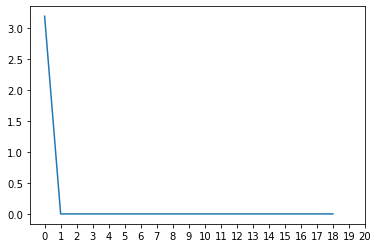

In [74]:
plt.plot(avg_error_list)
plt.xticks(np.arange(21))


([<matplotlib.axis.XTick at 0x7f9506d7d8b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

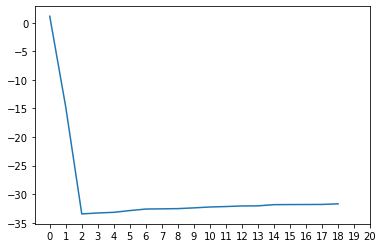

In [75]:
plt.plot(np.log(np.array(avg_error_list)))
plt.xticks(np.arange(21))


In [56]:
# # For perfect match of conjectured and true n (i.e., neither overfitting nor underfitting):
# plt.plot(np.linalg.norm((theta_array - theta_ground_truth), axis=1))

In [45]:
# begin_time = time.time()

# m_list = [2*x + 2 for x in list(range(10))]
# rho_min_list = [x * 0.01 + 0.01 for x in list(range(5))]
# input_indices_true = list(range(num_outputs, num_outputs + num_inputs))
# num_trials = 10

# false_positive_avg_array = np.zeros((len(m_list), len(rho_min_list)))
# missed_detection_avg_array = np.zeros((len(m_list), len(rho_min_list)))

# for count_m, m in enumerate(m_list):
#     print("\n")
#     print("count_m:", count_m)
#     for count_rho, rho_min in enumerate(rho_min_list):
#         print("count_rho", count_rho)
#         false_positive_quantity_list = []
#         missed_detection_quantity_list = []
#         for trial_id in range(num_trials):
#             input_indices_est = correlation_test(traj_dataset, m, rho_min)
#             false_positive_quantity_list.append(len([k for k in input_indices_est if k not in input_indices_true]))
#             missed_detection_quantity_list.append(len([k for k in input_indices_true if k not in input_indices_est]))
#         false_positive_avg_array[count_m, count_rho] = sum(false_positive_quantity_list)/len(false_positive_quantity_list)
#         missed_detection_avg_array[count_m, count_rho] = sum(missed_detection_quantity_list)/len(missed_detection_quantity_list)

# end_time = time.time()
# print("\nTime:", end_time - begin_time)

# # print(correlation_test(traj_dataset, 10, 0.05))



In [46]:
# input_indices_est

In [47]:
# print(false_positive_avg_array)
# print(missed_detection_avg_array)

In [48]:
m = 20
rho_min = 0.02

# for i in range(num_quantities):
#     print("\ni:", i)
#     for j in range(num_quantities):
#         print("j:", j, "corr:", sp.stats.pearsonr(traj_dataset[:, j, 0], traj_dataset[:, i, 1])[0])

# print(traj_dataset[:, 10, 0])
# print(traj_dataset[:, 15, 1])

# correlation_test(traj_dataset, m, rho_min)


In [49]:
# # Save results:

# path_directory = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"

# path_file = path_directory + "false_positive_avg_array.csv"
# false_positive_avg_array_pd = pd.DataFrame(false_positive_avg_array)
# false_positive_avg_array_pd.to_csv(path_file, index=False)

# path_file = path_directory + "missed_detection_avg_array.csv"
# missed_detection_avg_array_pd = pd.DataFrame(missed_detection_avg_array)
# missed_detection_avg_array_pd.to_csv(path_file, index=False)



# Scratch Work

In [ ]:
# list_1 = [3, 4, 5]
# list_2 = [4, 5, 6]

# list_1_not_2 = [k for k in list_1 if k not in list_2]
# list_2_not_1 = [k for k in list_2 if k not in list_1]

In [7]:
A = np.array([[-1, 0, 0, 0, 0], [1, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, -1, 0], [0, 0, 0, 0, -2]])
B = np.array([[1, -1, -1], [0, 0, 0], [0, 3, 1], [-1, 3, 2], [1, -3, -2]])
C = np.array([[1, 0, -1, -1,-1], [0, 1, 3, 1, 0], [-1, 1, 3, 2, 1]])

ctrl_gram = np.block([B, A @ B, A @ A @ B, A @ A @ A @ B, A @ A @ A @ A @ B])
observ_gram = np.block([[C], [C @ A], [C @ A @ A], [C @ A @ A @ A], [C @ A @ A @ A @ A]])

_, S_ctrl, _ = np.linalg.svd(ctrl_gram)
_, S_observ, _ = np.linalg.svd(observ_gram)

print(S_ctrl)
print("\n")
print(S_observ)

[70.13372346  7.49124929  4.61401113  1.65211256  0.35134451]


[27.77084887 11.03912218  3.4165928   1.4057661   0.51812137]
